##### Copyright 2019 The TensorFlow Authors.



In [0]:
#@title Licensed under the Apache License, Version 2.0
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Addons Layers: WeightNormalization

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/addons/blob/master/examples/layers_weightnormalization.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/addons/blob/master/examples/layers_weightnormalizations.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Overview

This notebook will demonstrate how to use the Weight Normalization layer and how it can improve convergence.


# WeightNormalization

A Simple Reparameterization to Accelerate Training of Deep Neural Networks:

Tim Salimans, Diederik P. Kingma (2016)

> By reparameterizing the weights in this way we improve the conditioning of the optimization problem and we speed up convergence of stochastic gradient descent. Our reparameterization is inspired by batch normalization but does not introduce any dependencies between the examples in a minibatch. This means that our method can also be applied successfully to recurrent models such as LSTMs and to noise-sensitive applications such as deep reinforcement learning or generative models, for which batch normalization is less well suited. Although our method is much simpler, it still provides much of the speed-up of full batch normalization. In addition, the computational overhead of our method is lower, permitting more optimization steps to be taken in the same amount of time.

> https://arxiv.org/abs/1602.07868 

<img src="https://raw.githubusercontent.com/seanpmorgan/tf-weightnorm/master/static/wrapped-graph.png" width="80%"><br><br>


## Setup

In [0]:
!pip install tensorflow-gpu==2.0.0.a0
!pip install tensorflow-addons
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from matplotlib import pyplot as plt

In [0]:
# Hyper Parameters
batch_size = 32
epochs = 10
num_classes=10

# Build Models

In [0]:
# Standard ConvNet
reg_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, 5, activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, 5, activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax'),
])

In [0]:
# WeightNorm ConvNet
wn_model = tf.keras.Sequential([
    tfa.layers.WeightNormalization(tf.keras.layers.Conv2D(6, 5, activation='relu')),
    tf.keras.layers.MaxPooling2D(2, 2),
    tfa.layers.WeightNormalization(tf.keras.layers.Conv2D(16, 5, activation='relu')),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(120, activation='relu')),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(84, activation='relu')),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(num_classes, activation='softmax')),
])

# Load Data

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Train Models

In [0]:
reg_model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

reg_history = reg_model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            shuffle=True)

In [0]:
wn_model.compile(optimizer='adam', 
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

wn_history = wn_model.fit(x_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(x_test, y_test),
                          shuffle=True)

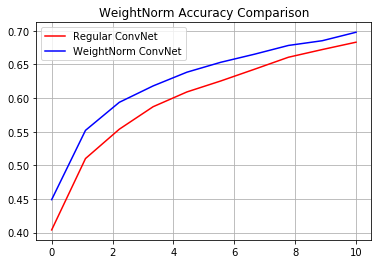

In [0]:
reg_accuracy = reg_history.history['accuracy']
wn_accuracy = wn_history.history['accuracy']

plt.plot(np.linspace(0, epochs,  epochs), reg_accuracy,
             color='red', label='Regular ConvNet')

plt.plot(np.linspace(0, epochs, epochs), wn_accuracy,
         color='blue', label='WeightNorm ConvNet')

plt.title('WeightNorm Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()